In [1]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
from datetime import datetime
import pandas_datareader.data as web

In [2]:
tech_list = ['AAPL', 'GOOGL', 'MSFT', 'AMZN']

In [3]:
# identify a time period when stock would be analyzed 
year = datetime.today().year
month = datetime.today().month
day = datetime.today().day
end = "%s-%s-%s" %(year-1,month,day)
start = "%s-%s-%s" %(year-2,month,day)

In [4]:
# pull data from quandl
for stock in tech_list:
    globals()[stock] = web.DataReader(stock, 'quandl', start, end, access_key="2R89GBx5133ux-s5Gmad")

<h2> Basic Analysis </h2>

In [5]:
def basic_plot (df, company_name):
    fig1 = plt.figure()
    plt.subplot(211)
    df['AdjClose'].plot(figsize=(18,10), color='r')
    plt.ylabel("Adjusted Closing Price (US dollar)", fontsize=15)
    plt.title("%s Stock from %s to %s" %(company_name, start,end), fontsize=20) 
    
    plt.subplot(212)
    df['Volume'].plot(figsize=(18,10))
    plt.title("%s Stock from %s to %s" %(company_name, start,end), fontsize=20) 
    plt.ylabel("Number of Shares", fontsize=15)
    
    plt.tight_layout()
    filename = 'basic_%s.png' %(company_name)
    fig1.savefig(filename)

    plt.clf()
    return 

In [6]:
def moving_avg (df, company_name):
    MA_day = [20,30,50]
    for MA in MA_day:
        column_name = "MA for %s days" %(str(MA))
        df[column_name] = AAPL['AdjClose'].rolling(MA).mean()
        
    fig2 = df[['AdjClose', 'MA for 20 days', 'MA for 30 days', 'MA for 50 days']].plot(legend=True, figsize=(18,8))
    plt.title('Moving Average of %s Stock from %s to %s' %(company_name, start,end), fontsize=20)
    plt.ylabel("(US dollar)", fontsize=15)
    fig2.savefig('movingavg_%s.png' %(company_name))
    plt.clf()
    return 

In [7]:
def daily_return (df, company_name):
    plt.figure()
    plt.subplot(211)
    df['Daily Return'] = df['AdjClose'].pct_change()
    df['Daily Return'].multiply(100).plot(figsize=(10,5), marker='o')
    plt.ylabel('Daily Return Percentage')
    plt.title('%s Stock from %s to %s' %(company_name, start,end), fontsize=20)
    
    plt.subplot(212)
    sns.distplot(df['Daily Return'].dropna(), bins=100, color='green')
    plt.xlabel('Daily Return Percentage')
    plt.title('%s Stock from %s to %s' %(company_name, start,end), fontsize=20)
    
    plt.tight_layout()
    return

In [8]:
basic_plot(AAPL, 'Apple')
basic_plot(GOOGL, 'Google')
basic_plot(AMZN, 'Amazon')
basic_plot(MSFT, 'Microsoft')

<Figure size 1296x720 with 0 Axes>

<Figure size 1296x720 with 0 Axes>

<Figure size 1296x720 with 0 Axes>

<Figure size 1296x720 with 0 Axes>

<h2> Comparison </h2>

In [9]:
closing_df = pd.DataFrame(list([AAPL['AdjClose'],GOOGL['AdjClose'],MSFT['AdjClose'],AMZN['AdjClose']])).T
closing_df.columns = ['AAPL', 'GOOGL', 'MSFT', 'AMZN']

In [10]:
# calculate daily percentage return
tech_rets = closing_df.pct_change()

In [11]:
def joint_plot (company1, company2):
    g = g.plot_joint(plt.scatter, color = 'green')
    g = g.plot_marginals(sns.distplot, kde=False, color="green")
    g.annotate(stats.pearsonr, fontsize=13)
    plt.clf()
    return 

In [12]:
# HOW TO USE pairplot AND pairgrid

# f = sns.pairplot(data=tech_rets.dropna(), height=7)

# j = sns.PairGrid(tech_rets.dropna(), height=7)
# j.map_upper(plt.scatter, color='purple')
# j.map_lower(sns.kdeplot, cmap='Blues_d')
# j.map_diag(plt.hist, bins=20)

# j = sns.PairGrid(closing_df.dropna(), height=7)
# j.map_upper(plt.scatter, color='purple')
# j.map_lower(sns.kdeplot, cmap='Blues_d')
# j.map_diag(plt.hist, bins=20)

In [13]:
tech_rets.corr(method='pearson')

,AAPL,GOOGL,MSFT,AMZN
AAPL,1.000000,0.617704,0.634702,0.517927
GOOGL,0.617704,1.000000,0.775631,0.625175
MSFT,0.634702,0.775631,1.000000,0.675461
AMZN,0.517927,0.625175,0.675461,1.000000


In [14]:
closing_df.corr(method='pearson')

,AAPL,GOOGL,MSFT,AMZN
AAPL,1.000000,0.800419,0.809815,0.705341
GOOGL,0.800419,1.000000,0.944834,0.839070
MSFT,0.809815,0.944834,1.000000,0.944854
AMZN,0.705341,0.839070,0.944854,1.000000


<h2> Risk Analysis </h2>

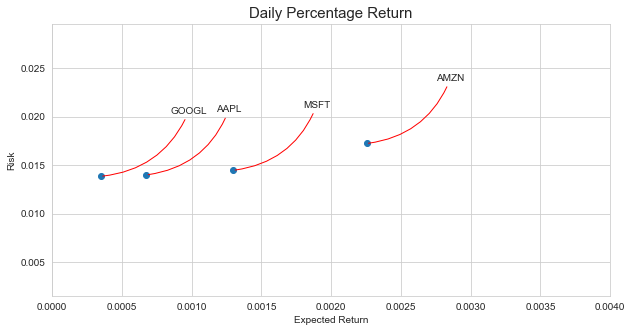

In [15]:
rets = tech_rets.dropna()
plt.figure(figsize=(10,5))
plt.scatter(x=rets.mean(), y=rets.std())
plt.xlim(0,0.004)
# standard deviation is risk 
plt.xlabel('Expected Return')
plt.ylabel('Risk')
plt.title('Daily Percentage Return', fontsize=15)
for label, x, y in zip(rets.columns, rets.mean(), rets.std()):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (70, 70),
        textcoords = 'offset points', ha = 'left', va = 'top',
        arrowprops = dict(arrowstyle = '-', connectionstyle = 'arc3,rad=-0.3', color='r'))

<h2> Value at Risk: Empirical Quantiles </h2>

In [16]:
rets['GOOGL'].quantile(0.01)

-0.045791093581828896

In [17]:
rets['AAPL'].quantile(0.01)

-0.02835052582957094

In [18]:
rets['AMZN'].quantile(0.01)

-0.039386791294659926

In [19]:
rets['MSFT'].quantile(0.01)

-0.04053454922275178

<h2> Value at Risk: Monte Carlo

In [20]:
def monte_carlo (start_price,dt,mu,sigma,days):
    price=np.zeros(days)
    shock=np.zeros(days)
    drift=np.zeros(days)
    price[0]=start_price
    
    for i in range(1,days):
        shock[i] = np.random.normal(loc=mu*dt, scale=sigma*np.sqrt(dt))
        drift[i] = mu*dt 
        price[i] = price[i-1] + price[i-1]*(drift[i] + shock[i])
    return price
            

In [21]:
start_price = {
    'GOOGL' : GOOGL['AdjClose'].iloc[0],
    'AMZN' : AMZN['AdjClose'].iloc[0],
    'MSFT' : MSFT['AdjClose'].iloc[0],
    'AAPL' : AAPL['AdjClose'].iloc[0]
}

In [22]:
def simulation_monte_carlo(company):
    days=365
    dt=1/days
    mu=rets['%s' %(company)].mean()
    sigma=rets['%s' %(company)].std()
    
    runs = 500
    simulation = np.zeros(runs)
    start = start_price['%s' %(company)]
    for j in range(runs):
        simulation[j] = monte_carlo(start,dt,mu,sigma,days)[-1]
        
    plt.figure(figsize=(10,5))    
    plt.hist(simulation,bins=100)
    plt.xlabel('US dollar')
    plt.title('Monte Carlo Simulation of %s Stock' %(company), fontsize=15)
    
    mean = simulation.mean()
    return mean

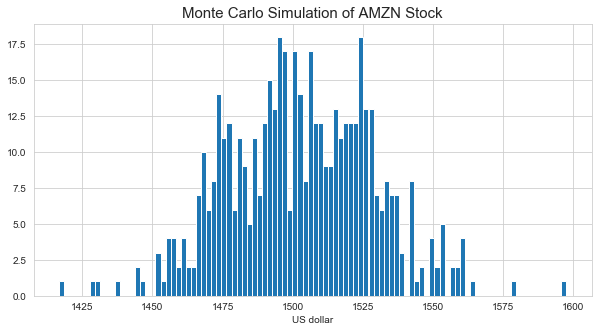

In [23]:
ngan = simulation_monte_carlo('AMZN')

In [24]:
ngan

1502.8946740234915